## Lending Club is a "Market Place Lender" which allows an individual to apply for a personal loan to be filled by the market, as opposed to a bank or other specialty lender.   They have grown in success and to date have closed over $3Bn in loans.    Lending Club has made loan and performance information freely available on their website. 

The data is available on the Lending Club website (https://www.lendingclub.com/info/download-data.action).   I manually downloaded the CSV files and stored them locally.   I am using only one subset of the total lending club data.  

My objectives in this project are threefold:
    i) Learn how to view, clean and manipulate large datasets;
    ii)Develop intuition for fitting estimators to the data;
    iii) What are the best predictors of borrower default? 
    iv) What rates do borrowers pay versus their other financial options?
    v) What are the best predictors of early borrower repayment? 
    vi) Start to develop a better way to predict creditworthiness of borrowers beyond the standard methods (eg, FICO); 
        a) For example, can we parse their loan purpose comments to develop a predictor of default?
        b) Can I take location information (eg, via zip codes) to get a better understanding the regional economy? 
        c) Ultimately, I would like to also use complementary external data sources to allow better prediction. 

## AS OF THE END DATE OF THE COURSE:  
A lot of time has been spent on cleaning, scrubbing, and understanding the organization of the data.   I had to generate some calculated features, and further projects include parsing the text fields.   


 ### This spreadsheet will be modified to do the file cleaning, with analysis and visualisation in separate notebook. 
 I will take the 4 Lending Club CSV files to see if they can be 'stitched' together for processing. 
 
 22 June 15 - Added file write and append logic.   Features selected for write operation to be consistent with merge
 31 July 15 - Attemping to merge all feature engineering and cleaning into this spradsheet.  Added 'days to default' feature.   Subsequent (separate) notebooks will do graphing and analysis.   
 
 05 Aug - Broke up notebook into three separate notebooks:
     i) File opening, cleaning, and appending (THIS ONE)
     ii) Graphs
     iii) Stats
     
The graph and stats notebooks work off the same file created here (currently named Lending_Club_CLEANED_V2.csv).  Some Jiggery Pokery required as LC files from 07-12 have slightly different file structure than later versions.   CUrrently no logic to handle this, as I manually comment/uncomment relevant fields.   

In [1]:
# load relevant libraries
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cross_validation import train_test_split
import seaborn as sns

%matplotlib inline

#import dataset
# Also, check why if header = 1 is used we seem to propogate NaN.
# Check file integrity of original file - noted gaps in the file used, manually correct. 

# url = "/Users/Glenn/Documents/LendingClub/LendingClub_07-12_Approved.csv"
# url = "/Users/Glenn/Documents/LendingClub/LendingClub_2015_Q1.csv"
#  
#                              iii) LendingClub_2014_Approved.csv

# url = "/Users/Glenn/Documents/LendingClub/LendingClub_12-13.csv"
# url = "/Users/Glenn/Documents/LendingClub/LendingClub_13-14.csv"
# url = "/Users/Glenn/Documents/LendingClub/LendingClub_07-12_Approved_29MAY.csv"
## THESE ARE MOST RECENT URLs FROM AUG 03 LC DOWNLOAD...

url = "/Users/Glenn/Documents/LendingClub/Data/03AUG15/LC_Data_07-12_03AUG15.csv"
# url = "/Users/Glenn/Documents/LendingClub/Data/03AUG15/LC_Data_12-13_03AUG15.csv"
# url = "/Users/Glenn/Documents/LendingClub/Data/03AUG15/LC_Data_13-14_03AUG15.csv"
# url = "/Users/Glenn/Documents/LendingClub/Data/03AUG15/LC_Data_15_03AUG15.csv"

lcd_raw = pd.read_csv(url,skiprows=1,
            parse_dates=['last_pymnt_d','issue_d','last_credit_pull_d','last_pymnt_d','next_pymnt_d'])

/Applications/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1159: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [2]:
lcd_raw.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
42533,72176,70868,2525,2525,225,36 months,9.33%,80.69,B,B3,...,0,2010-06-03,82.03,2010-07-03,2007-05-03,714,710,NaN,NaN,1
42534,71623,70735,6500,6500,0,36 months,8.38%,204.84,A,A5,...,0,2010-06-03,205.32,2010-07-03,2007-08-03,724,720,NaN,NaN,1
42535,70686,70681,5000,5000,0,36 months,7.75%,156.11,A,A3,...,0,2010-06-03,156.39,2010-07-03,2015-02-03,794,790,NaN,NaN,1
42536,Total amount funded in policy code 1: 471701350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
42537,Total amount funded in policy code 2: 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN


In [3]:
# Clean bottom of file and create new dataframe from it
lcd = lcd_raw[:-2].copy()

# Create Datetime fields from date information....
# lcd = lcd.drop(lcd.index[lcd.last_pymnt_d == 'nan'])
lcd['last_pymnt_date'] = [pd.to_datetime(j, format='%b-%Y', unit = "D") for j in lcd.last_pymnt_d]
lcd['next_pymnt_date'] = [pd.to_datetime(j,format='%b-%Y', unit = "D") for j in lcd.next_pymnt_d]
lcd['last_credit_pull_date'] = [pd.to_datetime(j, unit = "D",format='%b-%Y') for j in lcd.last_credit_pull_d]
lcd['issue_date'] = [pd.to_datetime(j, format='%b-%Y', unit = "D") for j in lcd.issue_d]


In [4]:
lcd = lcd[pd.notnull(lcd.loan_amnt) & pd.notnull(lcd.last_pymnt_d)]

In [5]:
lcd.isnull().sum()

id                                 0
member_id                          0
loan_amnt                          0
funded_amnt                        0
funded_amnt_inv                    0
term                               0
int_rate                           0
installment                        0
grade                              0
sub_grade                          0
emp_title                       2615
emp_length                         0
home_ownership                     0
annual_inc                         4
verification_status                0
issue_d                            0
loan_status                        0
pymnt_plan                         0
url                                0
desc                           13264
purpose                            0
title                             12
zip_code                           0
addr_state                         0
dti                                0
delinq_2yrs                       29
earliest_cr_line                  29
f

In [6]:
# Substitute "No Response" for any #NA in title, desc, emp_title features
lcd.title.fillna(value = "No response",inplace = True)
lcd.desc.fillna(value="No response", inplace = True)
lcd.emp_title.fillna(value="No response", inplace = True)

In [7]:
# replace all Nan's for 'mnths_since_last_delinq',  with 999....this is a kludge for now.  If this feature is used in logistic
# Regression, we'll want to make sure its far away from the other real delinquencies...
lcd['mths_since_last_delinq'].fillna(value=999, inplace=True)
lcd['mths_since_last_record'].fillna(value=999,inplace=True)
lcd['mths_since_last_major_derog'].fillna(value=999,inplace = True)
# lcd['mths_since_last_delinq'].unique()

In [8]:
#  Convert Field Employment Length into a numeric...
#lcd.emp_length.unique()
#array(['10+ years', , '1 year', '3 years', '8 years', '9 years',
#        '4 years', '5 years', '6 years', '2 years', '7 years', 'n/a'], dtype=object)

lcd['emp_length_numeric'] = lcd['emp_length'].map({'< 1 year':0, '1 year':1, '2 years':2, '3 years':3, 
                                                  '4 years':4,'5 years':5,'6 years':6,'7 years':7,
                                                  '8 years':8,'9 years':9,'10+ years':10})

# Now graph
# lcd['emp_length_numeric'].hist()
# plt.title('Employment Length counts')
# plt.xlabel('Employment Length (yrs)')

Employment length reasonably evenly distributed out to 5 years.    How is this distributed versus FICO score?

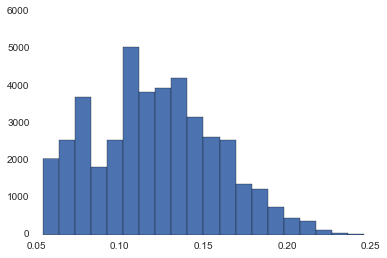

In [9]:
# Strip chars, convert int_rate series to float
lcd.int_rate.fillna(method='backfill',inplace = True)
lcd['clean_rate'] = [float(t.strip(' %'))/100 for t in lcd.int_rate]

# Now graph!
lcd['clean_rate'].hist(bins=20)

In [10]:
# clean term by splitting on spaces and converting numbers into float
lcd.term.fillna(method='backfill',inplace = True)
lcd['clean_term'] = [float (s.split(' ')[1]) for s in lcd.term]

In [11]:
# Calculate time to default, assumes we will flag the correct values through state variable

lcd = lcd[pd.notnull(lcd.last_pymnt_date) & pd.notnull(lcd.issue_date)]
lcd['time_to_default'] = lcd['last_pymnt_date'] - lcd['issue_date']
lcd['time_to_default'] = [j.days for j in lcd.time_to_default]
lcd['mos_to_default'] = [round(float(j/30),0) for j in lcd.time_to_default]

# Create normalized mos to default. 
lcd['mos_to_default_norm'] = lcd['mos_to_default']/lcd['clean_term']
lcd['mos_to_default_norm'] = [min(i,1) for i in lcd.mos_to_default_norm]

In [12]:
# Create Sub Grade map 
# print lcd['sub_grade'].unique()
#['B2' 'C4' 'C5' 'C1' 'B5' 'A4' 'E1' 'F2' 'C3' 'B1' 'D1' 'A1' 'B3' 'B4' 'C2'
# 'D2' 'A3' 'A5' 'D5' 'A2' 'E4' 'D3' 'D4' 'F3' 'E3' 'F4' 'F1' 'E5' 'G4' 'E2'
# 'G3' 'G2' 'G1' 'F5' 'G5']

lcd['sub_grade_int']=lcd['sub_grade'].map({'A1':0,'A2':1,'A3':2,'A4':3,'A5':4,
                                           'B1':5,'B2':6,'B3':7,'B4':8,'B5':9,
                                           'C1':10,'C2':11,'C3':12,'C4':13,'C5':14,
                                           'D1':15,'D2':16,'D3':17,'D4':18,'D5':19,
                                           'E1':20,'E2':21,'E3':22,'E4':23,'E5':24,
                                           'F1':25,'F2':26,'F3':27,'F4':28,'F5':29,
                                           'G1':30,'G2':31,'G3':32,'G4':33,'G5':34})

In [13]:
# Create Categorical Variable from LC grades
lcd['grade_int']=lcd['grade'].map({'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6})

In [14]:
#  THIS IS A KLUDGE TO GET RID OF NAs BY USING BACKFILL....

lcd['grade_int'].fillna(method = 'backfill',inplace = True)
lcd['sub_grade_int'].fillna(method='backfill',inplace=True)
lcd['purpose'].fillna(method = 'backfill',inplace = True)


In [15]:
# Use One Hot Encoder to turn Grade, Grade_Int into categorical variables
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
encoded_grade_status = ohe.fit_transform(lcd[['grade_int']])

# Convert to dataframe and add to lcd
grade_status_columns = ('A','B','C','D','E','F','G')
grade_status_encoded_dataframe = pd.DataFrame(encoded_grade_status, columns=grade_status_columns)

# Add to lcd dataframe at end so we avoid problems with re-running cells

# Now do the same for subgrade.   
encoded_sub_grade_status = ohe.fit_transform(lcd[['sub_grade_int']])
sub_grade_status_columns = ('A1','A2','A3','A4','A5',
                            'B1','B2','B3','B4','B5',
                            'C1','C2','C3','C4','C5',
                            'D1','D2','D3','D4','D5',
                            'E1','E2','E3','E4','E5',
                            'F1','F2','F3','F4','F5',
                            'G1','G2','G3','G4','G5')
sub_grade_status_encoded_dataframe = pd.DataFrame(encoded_sub_grade_status, columns=sub_grade_status_columns)


In [16]:
lcd.purpose.unique()

array(['credit_card', 'car', 'small_business', 'other', 'wedding',
       'debt_consolidation', 'home_improvement', 'major_purchase',
       'medical', 'moving', 'vacation', 'house', 'renewable_energy',
       'educational'], dtype=object)

In [17]:
# Use One Hot Encoder to turn Grade, Grade_Int into categorical variables
# from sklearn.preprocessing import OneHotEncoder

lcd.purpose.unique()


# This is for 07-12 File.  "Education" Purpose removed in subsequent files.
lcd['purpose_int']= lcd['purpose'].map({'credit_card':0, 'car':2, 'small_business':3, 'other':4, 
                                        'wedding':5,'debt_consolidation':6, 'home_improvement':7, 
                                        'major_purchase':8, 'medical':9, 'moving':10, 'vacation':11, 
                                        'house':12, 'renewable_energy':13,'educational':14})
'''

lcd['purpose_int']= lcd['purpose'].map({'credit_card':0, 'car':2, 'small_business':3, 'other':4, 
                                        'wedding':5,'debt_consolidation':6, 'home_improvement':7, 
                                        'major_purchase':8, 'medical':9, 'moving':10, 'vacation':11, 
                                        'house':12, 'renewable_energy':13})
'''

ohe = OneHotEncoder(sparse=False)
encoded_purpose = ohe.fit_transform(lcd[['purpose_int']])


# See above comments for 07-12 file 
purpose_columns = ('PURP:credit_card', 'PURP:car', 'PURP:small_business', 'PURP:other', 'PURP:wedding',
       'PURP:debt_consolidation', 'PURP:home_improvement', 'PURP:major_purchase',
       'PURP:medical', 'PURP:moving', 'PURP:vacation', 'PURP:house', 'PURP:renewable_energy',
       'PURP:educational')
'''
purpose_columns = ('PURP:credit_card', 'PURP:car', 'PURP:small_business', 'PURP:other', 'PURP:wedding',
       'PURP:debt_consolidation', 'PURP:home_improvement', 'PURP:major_purchase',
       'PURP:medical', 'PURP:moving', 'PURP:vacation', 'PURP:house', 'PURP:renewable_energy')
'''
purpose_encoded_dataframe = pd.DataFrame(encoded_purpose, columns= purpose_columns)

In [18]:
# print lcd['is_inc_v'].unique()
# ['Verified' 'Source Verified' 'Not Verified']

# backfill all NAs...in theory this might create some problems, but there aren't enough NAs to bias results. 
lcd['verification_status'].fillna(method='backfill',inplace = True)
lcd['verification_status_b'] = (lcd['verification_status']== 'VERIFIED - income') | (lcd['verification_status'] =='VERIFIED - income source')

In [19]:
lcd.home_ownership.unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE'], dtype=object)

In [20]:
# Convert Home ownership into categorical variable and encode using One Hot Encoder

# Map ownership type to categorical variable
lcd['home_ownership_int'] = lcd['home_ownership'].map({'RENT':0, 'OWN':1, 'MORTGAGE':2,'NONE':3,'OTHER':3})
# lcd['home_ownership_int'] = lcd['home_ownership'].map({'RENT':0, 'OWN':1, 'MORTGAGE':2,'ANY':3})

lcd['home_ownership_int'].fillna(method = 'backfill', inplace= True)
ohe = OneHotEncoder(sparse=False)

# Use OHE to convert to feature columns 
encoded_ownership_status = ohe.fit_transform(lcd[['home_ownership_int']])

# Now convert to dataframe and add to lcd
# Ownship Status columns reduced to 3.  "Other" not present in 2015 file
ownership_status_columns = ('HO - Rent','HO - Own','HO - Mortgage','HO - Other')

# 2015 file does not have 'Other' 
# ownership_status_columns = ('HO - Rent','HO - Own','HO - Mortgage')
ownership_encoded_dataframe = pd.DataFrame(encoded_ownership_status, columns=ownership_status_columns)

lcd = pd.concat([ownership_encoded_dataframe, lcd],axis=1)

In [21]:
# print lcd['pymnt_plan'].unique()
# ['n' 'y']

# Set up calculated feature which is boolean
lcd['pymnt_plan_bool']= (lcd['pymnt_plan']=='y').astype(bool)

In [22]:
# Define 'fico_interp' as midpoint between fico_range_low and fico_range_high

lcd['fico_interp']=(lcd['fico_range_low']+lcd['fico_range_high'])/2

In [23]:
lcd.loan_status.unique()

array(['Fully Paid', 'Charged Off', 'Current', nan, 'Late (31-120 days)',
       'In Grace Period', 'Default', 'Late (16-30 days)',
       'Does not meet the credit policy.  Status:Current',
       'Does not meet the credit policy.  Status:Charged Off',
       'Does not meet the credit policy.  Status:Fully Paid'], dtype=object)

In [24]:
'''
Defaults will become our Response variable (y)
FOR LENDING CLUB 07-12.CSV" file, there are additional fields "Does not meet the credit policy.
See notes from Lending Club call Jun17 15 for further info
 LOAN STATUS CATEGORIES 
'Fully Paid' 'Charged Off' 'Current' 'Default' 'Late (31-120 days)'
'In Grace Period' 'Late (16-30 days)'
'Does not meet the credit policy.  Status:Current'
'Does not meet the credit policy.  Status:Charged Off'
'Does not meet the credit policy.  Status:Fully Paid'
'Does not meet the credit policy.  Status:Late (16-30 days)'
'Does not meet the credit policy.  Status:In Grace Period'
'Does not meet the credit policy.  Status:Late (31-120 days)']

THIS IS FOR THE 07-12 LOAN FILE ONLY

'''
lcd['loan_status_int']=lcd['loan_status'].map({'Fully Paid':0,'Charged Off':1,'Current':2,'Default':3,
                            'Late (31-120 days)':4,'In Grace Period':5,'Late (16-30 days)':6,
                            'Does not meet the credit policy.  Status:Current':7,
                            'Does not meet the credit policy.  Status:Charged Off':8,
                            'Does not meet the credit policy.  Status:Fully Paid':9,
                            'Does not meet the credit policy.  Status:Late (16-30 days)':10,
                            'Does not meet the credit policy.  Status:In Grace Period':11,
                            'Does not meet the credit policy.  Status:Late (31-120 days)':12,
                            'Does not meet the credit policy.  Status:Default' :13}) 


In [162]:
#  This is for all files post 07-12 loan file

lcd['loan_status_int']=lcd['loan_status'].map({'Fully Paid':0,'Charged Off':1,'Current':2,'Default':3,
                            'Late (31-120 days)':4,'In Grace Period':5,'Late (16-30 days)':6})

lcd['loan_status'].unique()

array(['Current', 'In Grace Period', 'Fully Paid', 'Late (31-120 days)',
       nan, 'Charged Off', 'Late (16-30 days)', 'Default'], dtype=object)

In [25]:
# Convert loan status by using One Hot Encoder (OHE)

# THere's only one na, so this shouldn't bias our results tremendously...
lcd['loan_status_int'].fillna(method = 'backfill', inplace= True)

# Use OHE to create multiple features out of loan_status_int
encoded_loan_status = ohe.fit_transform(lcd[['loan_status_int']])

# Create a dataframe to add to lcd
'''
# This mapping is for 07-12 file which had exceptions to the credit policy


loan_status_columns = ('LS: Fully Paid','LS: Charged Off', 'LS: Current','LS: Default','LS: Late (31-120)',
                      'LS: Late (Grace Period}', 'LS: Late (16-30)', 'LS: Outside Credit Policy: Current',
                      'LS: Outside Credit Policy: Charged Off', 'LS: Outside Credit Policy: Fully Paid'
                      'LS: Outside Credit Policy: Late (16-30)', 'LS: Outside Credit Policy: Grace Period',
                      'LS: Outside Credit Policy: Late (31-120)', 'LS: Outside Credit Policy: (Default)')

## AS OF AUG 2015, loan_status columns for 07-12 file have changed.  
# This mapping is for 07-12 file which had exceptions to the credit policy

'''
loan_status_columns = ('LS: Fully Paid','LS: Charged Off', 'LS: Current','LS: Default','LS: Late (31-120)',
                      'LS: Late (Grace Period}', 'LS: Late (16-30)', 'LS: Outside Credit Policy: Current',
                      'LS: Outside Credit Policy: Charged Off', 'LS: Outside Credit Policy: Fully Paid')

'''


loan_status_columns = ('LS: Fully Paid','LS: Charged Off', 'LS: Current','LS: Default','LS: Late (31-120)',
                      'LS: Late (Grace Period}', 'LS: Late (16-30)')
'''

encoded_loan_status_dataframe = pd.DataFrame(encoded_loan_status, columns=loan_status_columns)


In [26]:
# Concat the categorical dataframes to lcd
lcd = pd.concat([lcd, grade_status_encoded_dataframe], axis=1)
lcd = pd.concat([lcd, sub_grade_status_encoded_dataframe], axis=1)
lcd = pd.concat([lcd, encoded_loan_status_dataframe], axis=1)
lcd = pd.concat([lcd, purpose_encoded_dataframe], axis=1)

# encoded_dataframe.head()

In [50]:
# lcd['Total_Defaults']= lcd['LS: Default']+lcd['LS: Charged Off']+lcd['LS: Outside Credit Policy: Charged Off']
lcd['Defaulted']= lcd['LS: Default']+lcd['LS: Charged Off']
lcd['Closed'] = lcd['LS: Default']+lcd['LS: Charged Off']+lcd['LS: Fully Paid']+lcd['LS: Outside Credit Policy: Charged Off']+lcd['LS: Outside Credit Policy: Fully Paid']
lcd['Defaulted'].sum()


5401.0

In [53]:
lcd['ROI'] = (lcd['total_pymnt']/lcd['funded_amnt'])**(12/lcd['clean_term'])-1
# lcd['ROI'] = lcd['total_pymnt']/lcd['funded_amnt']

In [45]:
lcd['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', nan, 'Late (31-120 days)',
       'In Grace Period', 'Default', 'Late (16-30 days)',
       'Does not meet the credit policy.  Status:Current',
       'Does not meet the credit policy.  Status:Charged Off',
       'Does not meet the credit policy.  Status:Fully Paid'], dtype=object)

In [54]:
# lcd[(lcd['Defaulted']==0) & ((lcd['loan_status']=='Fully Paid') | (lcd['loan_status']=='Charged Off') | (lcd['loan_status']=='In Grace Period'))].ROI.describe()
lcd[(lcd['Closed']==1)].ROI.describe()

count    39161.000000
mean         0.010981
std          0.107296
min         -0.829695
25%          0.022848
50%          0.041483
75%          0.059850
max          0.164457
Name: ROI, dtype: float64

In [168]:
lcd['HO - Other'] = 0

In [166]:
write_columns = ['HO - Rent',
 'HO - Own',
 'HO - Mortgage',
 'HO - Other',
 'id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'installment',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'last_pymnt_date',
 'next_pymnt_date',
 'last_credit_pull_date',
 'issue_date',
 'emp_length_numeric',
 'clean_rate',
 'clean_term',
 'verification_status_b',
 'pymnt_plan_bool',
 'fico_interp',
 'grade',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'A1',
 'A2',
 'A3',
 'A4',
 'A5',
 'B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'E1',
 'E2',
 'E3',
 'E4',
 'E5',
 'F1',
 'F2',
 'F3',
 'F4',
 'F5',
 'G1',
 'G2',
 'G3',
 'G4',
 'G5',
 'PURP:credit_card',
 'PURP:car',
 'PURP:small_business',
 'PURP:other',
 'PURP:wedding',
 'PURP:debt_consolidation',
 'PURP:home_improvement',
 'PURP:major_purchase',
 'PURP:medical',
 'PURP:moving',
 'PURP:vacation',
 'PURP:house',
 'PURP:renewable_energy',
 'Total_Defaults',
 'mos_to_default',
 'mos_to_default_norm']

In [169]:
# WRite file - if it exists, append to end without header.  If it doesn't already exist, write.
write_url ='/Users/Glenn/Documents/LendingClub/LendingClub_CLEANED_v2.csv'

import os
# if file does not exist write header 
if not os.path.isfile(write_url):
   lcd[write_columns].to_csv(write_url,header ='column_names')
else: # else it exists so append without writing the header
    lcd[write_columns].to_csv(write_url,mode = 'a',header=False)

In [170]:
lcd.shape

(84277, 141)

In [114]:
# cf_cohorts = lcd.groupby(lcd.issue_date)
# cf_cohorts = lcd[lcd.issue_date=='2008-01-19T19:00:00.000000000-0500']

In [54]:
# write_url = url.rsplit('.')[0]+'_CLEANED.csv'
# print write_url
# lcd.to_csv(write_url)

/Users/Glenn/Documents/LendingClub/LendingClub_13-14_CLEANED.csv


In [55]:
'''
# print lcd_temp2['issue_date'].dtype
# print lcd_temp2['last_pymnt_date'].dtype
#
# print lcd_temp2.issue_date.isnull().sum()
# print lcd_temp2.issue_date.unique()
# print lcd_temp2.last_pymnt_date.unique()
# print lcd_temp2.last_pymnt_date.isnull().sum()

# Calculated feature measures distance between last payment date and issue date. 
# However, default is only a subset of this. 
# For now, we'll let default flag determine if this really is time to default

# Drop  nulls implictly
lcd_temp = lcd[pd.notnull(lcd.last_pymnt_date) & pd.notnull(lcd.issue_date)]

# Calculate datetime 
lcd_temp['time_to_default']= (lcd_temp.last_pymnt_date - lcd_temp.issue_date)

# Convert to days
lcd_temp['time_to_default'] = [j.days for j in lcd_temp.time_to_default]
'''

"\n# print lcd_temp2['issue_date'].dtype\n# print lcd_temp2['last_pymnt_date'].dtype\n#\n# print lcd_temp2.issue_date.isnull().sum()\n# print lcd_temp2.issue_date.unique()\n# print lcd_temp2.last_pymnt_date.unique()\n# print lcd_temp2.last_pymnt_date.isnull().sum()\n\n# Calculated feature measures distance between last payment date and issue date. \n# However, default is only a subset of this. \n# For now, we'll let default flag determine if this really is time to default\n\n# Drop  nulls implictly\nlcd_temp = lcd[pd.notnull(lcd.last_pymnt_date) & pd.notnull(lcd.issue_date)]\n\n# Calculate datetime \nlcd_temp['time_to_default']= (lcd_temp.last_pymnt_date - lcd_temp.issue_date)\n\n# Convert to days\nlcd_temp['time_to_default'] = [j.days for j in lcd_temp.time_to_default]\n"